In [1]:
import os
import numpy as np
import pandas as pd

import torchxrayvision as xrv
import skimage, torch, torchvision

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

from sklearn.metrics import precision_recall_curve, precision_score, recall_score

/Users/rhussain/.pyenv/versions/3.9.13/envs/image/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
results = pd.DataFrame()

image_ids = []
image_path = []
true_label = []
for image in os.listdir('../images/train/nodule'):
    image_ids.append(image.split('.')[0])
    image_path.append(os.path.join('../images/train/nodule', image))
    true_label.append(1)

for image in os.listdir('../images/train/non_nodule'):
    image_ids.append(image.split('.')[0])
    image_path.append(os.path.join('../images/train/non_nodule', image))
    true_label.append(0)

for image in os.listdir('../images/test/nodule'):
    image_ids.append(image.split('.')[0])
    image_path.append(os.path.join('../images/test/nodule', image))
    true_label.append(1)

for image in os.listdir('../images/test/non_nodule'):
    image_ids.append(image.split('.')[0])
    image_path.append(os.path.join('../images/test/non_nodule', image))
    true_label.append(0)

results['image_id'] = image_ids
results['image_path'] = image_path
results['true_label'] = true_label

In [3]:
def classify_image(row):
    # Load the model
    model = xrv.models.get_model("densenet121-res224-all")

    # define transformer 
    transform = torchvision.transforms.Compose([xrv.datasets.XRayCenterCrop(),xrv.datasets.XRayResizer(224)])

    # Load the image
    img = skimage.io.imread(row['image_path'])
    img = xrv.datasets.normalize(img, 255)
    
    # Check that images are 2D arrays
    if len(img.shape) > 2:
        img = img[:, :, 0]
    if len(img.shape) < 2:
        print("error, dimension lower than 2 for image")

    # Add color channel
    img = img[None, :, :]

    # transform the image
    img = transform(img)

    # Classify the image
    output = {}
    with torch.no_grad():
        img = torch.from_numpy(img).unsqueeze(0)
        preds = model(img).cpu()
        output["preds"] = dict(zip(xrv.datasets.default_pathologies,preds[0].detach().numpy()))

    return output['preds']['Nodule']

In [4]:
results['prediction'] = results.apply(classify_image, axis=1)

In [5]:
precision, recall, thresholds = precision_recall_curve(results['true_label'], results['prediction'])

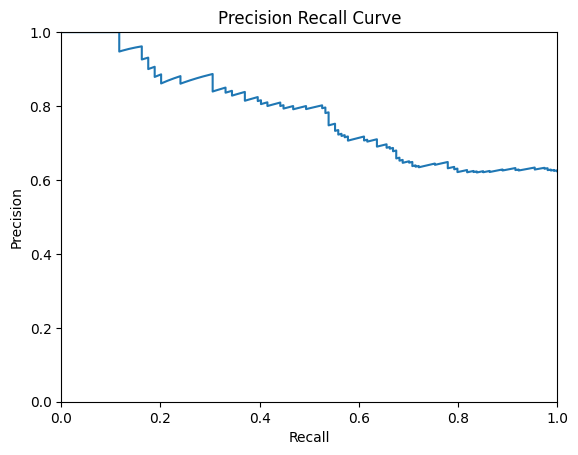

In [6]:
plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision Recall Curve")
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.show()

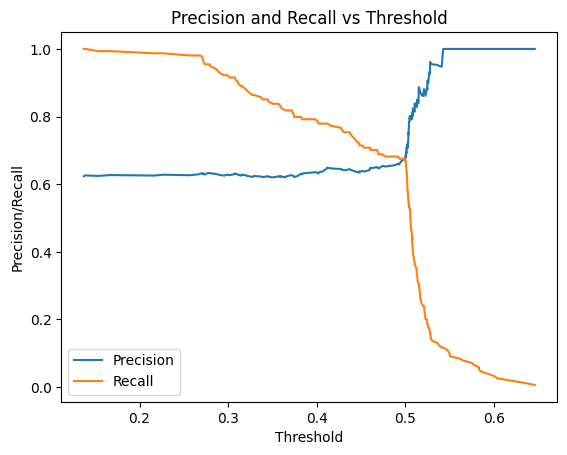

In [7]:
plt.plot(thresholds, precision[:-1], label="Precision")
plt.plot(thresholds, recall[:-1], label="Recall")
plt.xlabel("Threshold")
plt.ylabel("Precision/Recall")
plt.title("Precision and Recall vs Threshold")
plt.legend()
plt.show()

In [8]:
def threshold_prediction(row, threshold):
    if row['prediction'] >= threshold:
        return 1
    else:
        return 0

In [9]:
results['prediction_55'] = results.apply(threshold_prediction, args=(0.505,), axis=1)

In [10]:
precision_55 = precision_score(results['true_label'], results['prediction_55'])
recall_55 = recall_score(results['true_label'], results['prediction_55'])

print("Precision at 0.55 threshold: ", precision_55)
print("Recall at 0.55 threshold: ", recall_55)

Precision at 0.55 threshold:  0.801980198019802
Recall at 0.55 threshold:  0.525974025974026


In [11]:
f1_scores = 2*precision*recall/(precision+recall)
best_thresh = thresholds[np.argmax(f1_scores)]
best_f1 = np.max(f1_scores)
print("Best F1 score: ", best_f1)
print("Best threshold: ", best_thresh)

Best F1 score:  0.77
Best threshold:  0.13847966


In [12]:
threshs = list(thresholds)
threshs.append(0.64620733)

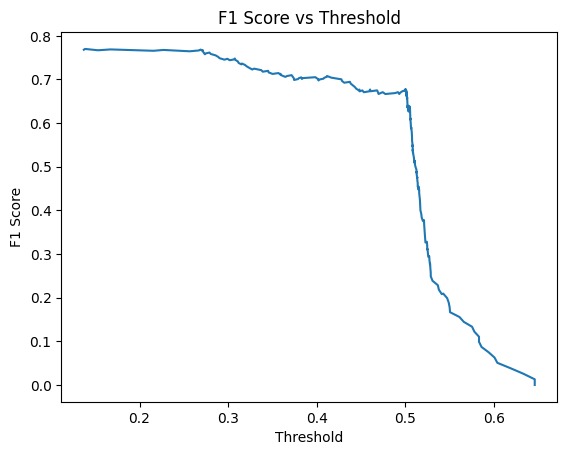

In [13]:
plt.plot(threshs, f1_scores)
plt.xlabel("Threshold")
plt.ylabel("F1 Score")
plt.title("F1 Score vs Threshold")
plt.show()